<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Library-and-Data-Import" data-toc-modified-id="Library-and-Data-Import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Library and Data Import</a></span></li><li><span><a href="#Pre-processsing" data-toc-modified-id="Pre-processsing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Pre-processsing</a></span></li><li><span><a href="#Extracting-cost-data-and-merging-with-the-applications/measures-database" data-toc-modified-id="Extracting-cost-data-and-merging-with-the-applications/measures-database-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Extracting cost data and merging with the applications/measures database</a></span><ul class="toc-item"><li><span><a href="#Plotting" data-toc-modified-id="Plotting-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Plotting</a></span></li></ul></li><li><span><a href="#Notes" data-toc-modified-id="Notes-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Notes</a></span></li><li><span><a href="#Old-code" data-toc-modified-id="Old-code-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Old code</a></span></li></ul></div>

# Library and Data Import

In [655]:
# Importing Python libraries necessary for the analysis
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pylab as plt
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from pandas_profiling import ProfileReport
import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(colorscale='plotly', world_readable=True)
# from bs4 import BeautifulSoup # Needed to read the html Wikipedia page

In [454]:
london_auths = ['City of London','City of Westminster','Kensington and Chelsea','Hammersmith and Fulham',
                    'Wandsworth','Lambeth','Southwark','Tower Hamlets','Hackney','Islington','Camden',
                    'Brent','Ealing','Hounslow','Richmond','Kingston','Merton','Sutton','Croydon','Bromley',
                    'Lewisham','Greenwich','Bexley','Havering','Barking and Dagenham','Redbridge','Newham',
                    'Waltham Forest','Haringey','Enfield','Barnet','Harrow','Hillingdon']

In [455]:
# Reading GHG Data file as a whole
xls_data = pd.ExcelFile('Copy of GHG Data - 10022021 - Master.xlsx', engine='openpyxl')

# Reading each sheet in the excel file seperately. If names of sheets change this command won't work
df_app = pd.read_excel(xls_data, sheet_name='Application Level')
df_meas = pd.read_excel(xls_data, sheet_name='Measure Level')

In [456]:
# Reading Cost Data file as a whole
xls_costs = pd.ExcelFile('Copy of Cost data master copy.xlsx', engine='openpyxl')

# Reading the cost parameters sheet
df_costs = pd.read_excel(xls_costs, sheet_name='Cost Fraud Control Parameters', header=[23])

# Pre-processsing

We need to clean the data before we start doing our analysis. This includes preparing the two datasets for merging, merging them etc.

In [457]:
# Removing unnecessary columns and rows

# Dropping columns with 'Unnamed' in their name. These are unnecessary columns 
df_costs = df_costs[df_costs.columns.drop(list(df_costs.filter(regex='Unnamed')))]

# Dropping rows with less than 3 non-NaN values and rows that are the same as the column names
df_costs.dropna(thresh=3, inplace=True)
df_costs = df_costs[(df_costs != df_costs.columns).all(axis=1)]

# Converting Measure column to be capitalised as with the GHG data measure column
df_costs['Primary Measure - Insulation'] = df_costs['Primary Measure - Insulation'].str.capitalize()
df_meas['Measure_Name'] = df_meas['Measure_Name'].str.capitalize()

We merge the measures and applications sheets of the data to collect all the data in one dataframe

In [458]:
# Merging datasets based on the same Application ID
apps_meas = pd.merge(df_meas, df_app, on=['Application_ID'])

We extract the number of rooms where rooms is the unit for the measure

In [459]:
# Extracting number of rooms and checking if they are above or below 4
apps_meas['insulated_rooms'] = apps_meas.apply(lambda row:'Less than 4' if row['Quantity_Units'] == 'Number of Rooms' and int(row['Quantity_of_Measure']) < 4
                                                 else '4 or more' if row['Quantity_Units'] == 'Number of Rooms' and int(row['Quantity_of_Measure']) >= 4
                                                 else 'None', axis=1)

In [460]:
# Setting property type to any for retrofit measures that don't distinguish between property type (in the apps/measures dataframe)
apps_meas['Property_Type_x'] = apps_meas.apply(lambda row: 'Any' if row['Measure_Name'] not in ['External solid wall insulation','Internal solid wall insulation','Cavity wall insulation'] else row['Property_Type_x'], axis=1)

# Setting property type to any for retrofit measures that don't distinguish between property type
df_costs['Unit Type \n(Insulation Qualifier)'].fillna('Any', inplace=True)

In [461]:
# Setting all remaining property types to equivalent property types in cost sheet
apps_meas['Property_Type_x'] = apps_meas.apply(lambda row: 'Semi-Detached/Terrace/Bungalow' if row['Measure_Name']=='Cavity wall insulation' and row['Property_Type_x'] in ['Bungalow','Semi-Detached/Terrace','Terraced House','Semi-Detached House','Semi-Detached','Mid-Terrace','End-Terrace','Bungalow: Semi-Detached & End Terrace','Bungalow: Mid Terrace']
                                               else 'Semi-Detached/Terrace' if row['Property_Type_x'] in ['Terraced House','Semi-Detached House','Semi-Detached','Mid-Terrace','End-Terrace','Bungalow: Semi-Detached & End Terrace','Bungalow: Mid Terrace']\
                                               else 'Detached' if row['Property_Type_x'] in ['Detached House','House: Detached','Park Home','Bungalow: Detached']
                                               else 'Flat' if row['Property_Type_x'] in ['Flat: 3 External Walls','Flat: 2 External Walls'] 
                                               else row['Property_Type_x'], axis=1)

# Setting all remaining property types to equivalent property types in cost sheet
apps_meas['Measure_Name'] = apps_meas.apply(lambda row: 'Door' if row['Measure_Name'] in ['Energy efficient replacement doors']\
                                               else 'Heating controls (control)' if row['Measure_Name'] in ['Heating controls']\
                                               else 'Air source heat pump - average' if row['Measure_Name'] in ['Air source heat pump','Hybrid heat pumps']\
                                               else 'Douple glazing' if row['Measure_Name'] in ['Double/triple glazing']\
                                               else 'Room in roof insulation' if row['Measure_Name'] in ['Room-in-roof insulation']\
                                               else 'Biomass boilers' if row['Measure_Name'] in ['Biomass boiler']\
                                               else 'Hot water thermostat' if row['Measure_Name'] in ['Hot water tank thermostats']\
                                               else 'Ground source heat pumps - average' if row['Measure_Name'] in ['Ground source heat pump']\
                                               else 'Loft insulation (board/wool)' if row['Measure_Name'] in ['Loft insulation']\
                                               else row['Measure_Name'], axis=1)

# Extracting cost data and merging with the applications/measures database

In [495]:
# Merging the cost and apps/measures dataframes on measure name and property type
merged = pd.merge(apps_meas,df_costs, left_on=['Measure_Name','Property_Type_x'], right_on=['Primary Measure - Insulation','Unit Type \n(Insulation Qualifier)'], how='left')

In [496]:
merged

,Project_Number_x,Application_ID,Property_Type_x,Scheme_Type_x,Voucher_Project_Number,Measure_ID,Installer_ID,Voucher_ID,Voucher_Application_Date,Voucher_Status,...,Unit,Average Cost Per Unit,25% Below Avg Cost,25% Above Avg Cost,50% Above Avg Cost,25% Below Avg Cost.1,25% Above Avg Cost.1,50% Above Avg Cost.1,Unit Type \n(Insulation Qualifier),# of Rooms Insulated (Insulation Qualifier)
0,UKGHCR28914,2AD54F84,Semi-Detached/Terrace,Main,UKGVCR106917,3D70B1A5711C4A4CBF2E717C4A2748E5,6238534.0,E266WPTD,2020-11-11,Voucher Application Incomplete,...,Wall,3500,875,4375,5250,1093.75,5468.75,6562.5,Semi-Detached/Terrace,NaN
1,UKGHCR6572,5858FE84,Any,Main,UKGVCR53517,519D053A16094DF088EB2ABB2EB52BDD,6238710.0,huRN6qMK,2020-12-09,Voucher Issued - Work in Progress,...,m2,56,14,70,84,14,70,84,Any,NaN
2,UKGHCR30273,90C5D76B,Any,Low income,UKGVCR53059,D097F98D89994BDCB668B520503E524C,6238277.0,NaN,2020-12-08,Application Received,...,per door,800,200,1000,1200,250,1250,1500,Any,NaN
3,UKGHCR30273,90C5D76B,Any,Low income,UKGVCR53060,93EF2F1E1ACF4F1EB89E678A92A34639,6238277.0,NaN,2020-12-08,Application Received,...,m2,25,6.25,31.25,37.5,7.8125,39.0625,46.875,Any,NaN
4,UKGHCR42460,07441A02,Any,Low income,UKGVCR54652,1930F099B9524ABB84997ECF860F8D2D,6238253.0,NaN,2020-12-11,Pre-Installation Flaw,...,m2,80,20,100,120,20,100,120,Any,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119698,UKGHCR36468,1D526701,Detached,Main,NaN,UKGHCR36468_Cavity wall insulation,NaN,NaN,NaT,Voucher Project not Created,...,Home Type,2000,500,2500,3000,625,3125,3750,Detached,NaN
119699,UKGHCR36468,1D526701,Any,Main,NaN,UKGHCR36468_Energy efficient replacement doors,NaN,NaN,NaT,Voucher Project not Created,...,per door,800,200,1000,1200,250,1250,1500,Any,NaN
119700,UKGHCR36468,1D526701,Any,Main,NaN,UKGHCR36468_Double/triple glazing,NaN,NaN,NaT,Voucher Project not Created,...,per window,800,200,1000,1200,250,1250,1500,Any,NaN
119701,UKGHCR36468,1D526701,Any,Main,NaN,UKGHCR36468_Flat roof insulation,NaN,NaN,NaT,Voucher Project not Created,...,m2,200,50,250,300,50,250,300,Any,NaN


In [497]:
# Picking the cost thresholds according to whether the Local authority is a London authority
merged['25%'] = merged.apply(lambda row: row['25% Below Avg Cost.1'] if row['Local_Authority'] in london_auths\
                                               else row['25% Below Avg Cost'], axis=1)

merged['125%'] = merged.apply(lambda row: row['25% Above Avg Cost.1'] if row['Local_Authority'] in london_auths\
                                               else row['25% Above Avg Cost'], axis=1)

merged['150%'] = merged.apply(lambda row: row['50% Above Avg Cost.1'] if row['Local_Authority'] in london_auths\
                                               else row['50% Above Avg Cost'], axis=1)

In [498]:
# Converting quantity of measure and quote amount columns to numerical to be able to calculate later on
cols = ['Quantity_of_Measure','Quote_Amount']
merged[cols] = merged[cols].apply(pd.to_numeric, errors='coerce')

# Calculating 25% and 125% of absolute cost 
merged.loc[:,'25%_cost'] = merged.loc[:,'Quantity_of_Measure']*merged.loc[:,'25%']
merged.loc[:,'125%_cost'] = merged.loc[:,'Quantity_of_Measure']*merged.loc[:,'125%']

# Defining status function to assess whether cost of measure is too high or low 
def status(row):
    if row['Quote_Amount'] < row['25%_cost']:
        val = 'Low'
    elif row['Quote_Amount'] > row['125%_cost']:
        val = 'High'
    else:
        val = 'Acceptable'
    return val

# Extractinng status
merged['Status'] = merged.apply(status, axis=1)

<AxesSubplot:ylabel='Measure_Name'>

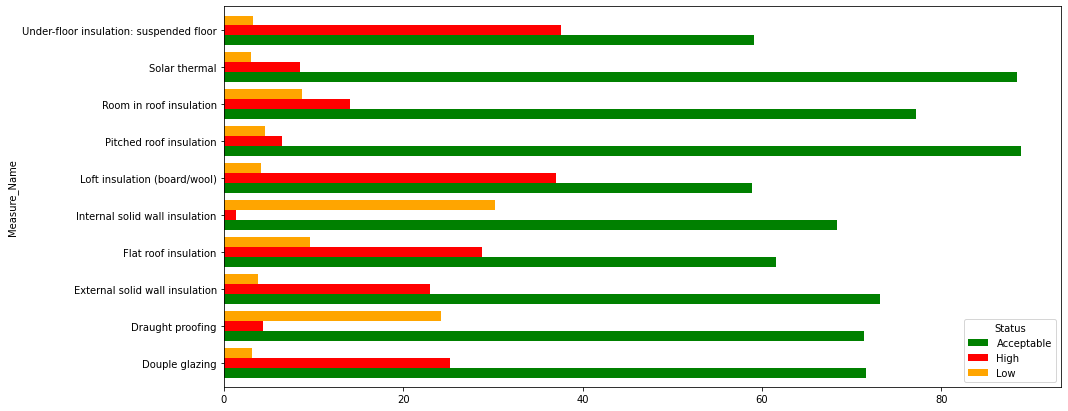

In [747]:
frame = pd.DataFrame(merged.groupby(['Measure_Name'])['Status'].value_counts(normalize=True)*100)
frame = frame.unstack().sort_values([('Status', 'High')],ascending=False)
frame['Total'] = merged.groupby(['Measure_Name'])['Status'].value_counts().unstack().sum(axis=1)

frame = frame[frame['Total']>100].sort_values([('Status','Acceptable')], ascending=False)[:10]
frame.sort_values(['Measure_Name'],)['Status'].plot.barh(figsize=(15,7), width=0.8, color=['g', 'r', '#FFA500'])

## Plotting

Here we plot the top 10 installers by percentage of high or low quotes. Installers with less than 50 measures are excluded:

In [756]:
sns.set_style('darkgrid')
@interact
def plot(Group_by = ['Installer_Company_Name','Measure_Name'], Cutoff=(1, 1000, 1),Sort_by=['Total',('Status','Acceptable'),('Status','High'),('Status','Low')], 
                            Top=(1, 50, 1), ):
    frame = pd.DataFrame(merged.groupby([Group_by])['Status'].value_counts(normalize=True)*100)
    frame = frame.unstack().sort_values([('Status', 'High')],ascending=False)
    frame['Total'] = merged.groupby([Group_by])['Status'].value_counts().unstack().sum(axis=1)
    
    frame = frame[frame['Total']>Cutoff].sort_values([Sort_by], ascending=False)[:Top]
    fig, ax = plt.subplots()
    frame.sort_values([Sort_by],)['Status'].plot.barh(figsize=(8,12), width=0.8, color=['g', 'r', '#FFA500'], ax=ax)
    ax.set_xlabel('Share of quote status (%)',fontsize=16)
    ax.set_ylabel('Installer',fontsize=16)
    for p in ax.patches:
        ax.annotate(str(p.get_width())[:4]+'%', (p.get_width()+2,p.get_y() * 1.01), fontsize=14)
        
    if Group_by == 'Measure_Name':
        groupby = 'measures'
        ax.set_ylabel('Measures',fontsize=16)
    else:
        groupby = 'installers'
        ax.set_ylabel('Installer',fontsize=16)
        
    if Sort_by == 'Total':
        ax.set_title(f'Top {Top} {groupby} by share of {Sort_by} status (Cutoff = {Cutoff})',fontsize=18)
    else:
        ax.set_title(f'Top {Top} {groupby} by share of {Sort_by[1]} status (Cutoff = {Cutoff})',fontsize=18)
    return frame.round(2)

interactive(children=(Dropdown(description='Group_by', options=('Installer_Company_Name', 'Measure_Name'), val…

Plotting by volume of quotes:

In [761]:
sns.set_style('darkgrid')
@interact
def plot(Group_by = ['Installer_Company_Name','Measure_Name'], Cutoff=(1, 1000, 1),Sort_by=['Total',('Status','Acceptable'),('Status','High'),('Status','Low')], 
                            Top=(1, 50, 1), ):
    frame = pd.DataFrame(merged.groupby([Group_by])['Status'].value_counts())
    frame = frame.unstack().sort_values([('Status', 'High')],ascending=False)
    frame['Total'] = merged.groupby([Group_by])['Status'].value_counts().unstack().sum(axis=1)
    
    frame = frame[frame['Total']>Cutoff].sort_values([Sort_by], ascending=False)[:Top]
    fig, ax = plt.subplots()
    frame.sort_values([Sort_by],)['Status'].plot.barh(figsize=(8,12), width=0.8, color=['g', 'r', '#FFA500'], ax=ax)
    ax.set_xlabel('Share of quote status (%)',fontsize=16)
    ax.set_ylabel('Installer',fontsize=16)
    for p in ax.patches:
        ax.annotate(str(int(p.get_width())), (p.get_width()+2,p.get_y() * 1.01), fontsize=14)
        
    if Group_by == 'Measure_Name':
        groupby = 'measures'
        ax.set_ylabel('Measures',fontsize=16)
    else:
        groupby = 'installers'
        ax.set_ylabel('Installer',fontsize=16)
        
    if Sort_by == 'Total':
        ax.set_title(f'Top {Top} {groupby} by volume of {Sort_by} status (Cutoff = {Cutoff})',fontsize=18)
    else:
        ax.set_title(f'Top {Top} {groupby} by volume of {Sort_by[1]} status (Cutoff = {Cutoff})',fontsize=18)
    return frame.round(2)

interactive(children=(Dropdown(description='Group_by', options=('Installer_Company_Name', 'Measure_Name'), val…

# Notes
1. Loft insulation has 2 types in the cost sheet but there's no information in the applications/measures sheet to distinguish between board and spray loft insulation measures. Currently applying all to board/wool.
2. Park homes in measures and applications but not in costs. Categorised as detached.
3. Extra semi-detached/terraced/bungalow unit type in costs sheet for cavity wall insulation measures
4. No way to distinguish between double and triple glazing measures in apps/measures sheet. Categorising all as double glazing.
5. No hybrid heat pumps in cost sheet. Currently assigning to air-source heat pump.

# Old code
Old function finding the costs for each measure and application. Took 5-6 minutes for 115000 rows. Too long.

In [ ]:
# def find_costs(row):
    
#     '''Function for identifying correct cost parameters depending on local authority, property type, measure
#     and other parameters.
#     '''
    
#     map_df = df_costs
    
#     london_auths = ['City of London','City of Westminster','Kensington and Chelsea','Hammersmith and Fulham',
#                     'Wandsworth','Lambeth','Southwark','Tower Hamlets','Hackney','Islington','Camden',
#                     'Brent','Ealing','Hounslow','Richmond','Kingston','Merton','Sutton','Croydon','Bromley',
#                     'Lewisham','Greenwich','Bexley','Havering','Barking and Dagenham','Redbridge','Newham',
#                     'Waltham Forest','Haringey','Enfield','Barnet','Harrow','Hillingdon']
    
#     qualified_measures = ['External solid wall insulation',
#                           'Internal solid wall insulation',
#                           'Cavity wall insulation']
    
#     if row['Local_Authority'].isin(london_auths).any():
#         # If local authority belongs to London authorities, filter for London costs
#         map_df = map_df[map_df.columns[~map_df.columns.str.endswith('Cost')]]
        
#     else:
#         # If local authority doesn't belong to London authorities, filter for normal costs
#         map_df = map_df[map_df.columns.drop(list(map_df.filter(regex='Cost.1')))]
        
#     # If the measure is one of the ones where the cost depends on the property type then match the cost to the right property type
#     if row['Measure_Name'].isin(qualified_measures).any():
#         if  row['Property_Type_x'].values[0] == 'Semi-Detached/Terrace' and row['Measure_Name'].values[0] == 'Internal solid wall insulation':
#             costs = map_df[(map_df['Primary Measure - Insulation'] == row['Measure_Name'].values[0]) & 
#                            (map_df['Unit Type \n(Insulation Qualifier)'] == row['Property_Type_x'].values[0]) &
#                           (map_df['# of Rooms Insulated (Insulation Qualifier)'] == row['insulated_rooms'].values[0])]
        
#         else:
#             costs = map_df[(map_df['Primary Measure - Insulation'] == row['Measure_Name'].values[0]) & 
#                                (map_df['Unit Type \n(Insulation Qualifier)'] == row['Property_Type_x'].values[0])]
#     else:
#         costs = map_df[map_df['Primary Measure - Insulation'] == row['Measure_Name'].values[0]]
      
#     return costs